Name | Matr.Nr. | Due Date
:--- | ---: | ---:
Mohamed Abdelaziz | 12137202 | 24.06.2022, 08:00

<h1 style="color:rgb(0,120,170)">Hands-on AI II</h1>
<h2 style="color:rgb(0,120,170)">Unit 6 &ndash; Introduction to Reinforcement Learning (Assignment)</h2>

<b>Authors:</b> B. Schäfl, S. Lehner, J. Brandstetter, E. Kobler<br>
<b>Date:</b> 30-05-2022

This file is part of the "Hands-on AI II" lecture material. The following copyright statement applies to all code within this file.

<b>Copyright statement:</b><br>
This material, no matter whether in printed or electronic form, may be used for personal and non-commercial educational use only. Any reproduction of this material, no matter whether as a whole or in parts, no matter whether in printed or in electronic form, requires explicit prior acceptance of the authors.

<h3 style="color:rgb(0,120,170)">How to use this notebook</h3>

This notebook is designed to run from start to finish. There are different tasks (displayed in <span style="color:rgb(248,138,36)">orange boxes</span>) which require your contribution (in form of code, plain text, ...). Most/All of the supplied functions are imported from the file <code>u6_utils.py</code> which can be seen and treated as a black box. However, for further understanding, you can look at the implementations of the helper functions. In order to run this notebook, the packages which are imported at the beginning of <code>u6_utils.py</code> need to be installed.

In [1]:
# Import pre-defined utilities specific to this notebook.
import u6_utils as u6

# Import additional utilities needed in this notebook.
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import sys
import time
import gym

from IPython import display
from typing import Tuple

# Set default plotting style.
sns.set()

# Setup Jupyter notebook (warning: this may affect all Jupyter notebooks running on the same Jupyter server).
u6.setup_jupyter()

# Check minimum versions.
u6.check_module_versions()

Installed Python version: 3.8 (✓)
Installed numpy version: 1.22.2 (✓)
Installed pandas version: 1.4.1 (✓)
Installed PyTorch version: 1.10.2+cu113 (✓)
Installed matplotlib version: 3.5.1 (✓)
Installed seaborn version: 0.11.2 (✓)
Installed gym version: 0.24.1 (✓)
Installed pygame version: 2.1.2 (✓)


<h2>Dissection of an Environment</h2>
<p>All exercises in this assignment are referring to the <i>FrozenLake</i> environment of <a href="https://www.gymlibrary.ml/"><i>OpenAI Gym</i></a>. This environment is described according to its official <a href="https://www.gymlibrary.ml/environments/toy_text/frozen_lake/">OpenAI Gym website</a>.
<center>
    <cite>Winter is here. You and your friends were tossing around a frisbee at the park when you made a wild throw that left the frisbee out in the middle of the lake. The water is mostly <span style="color:rgb(0,255,0)">frozen</span>, but there are a few <span style="color:rgb(255,0,0)">holes</span> where the ice has melted. If you step into one of those holes, you'll fall into the freezing water. At this time, there's an international frisbee shortage, so it's absolutely imperative that you navigate across the lake and retrieve the <span style="color:rgb(255,0,255)">disc</span>. However, the ice is slippery, so you won't always move in the direction you intend.</cite>
    </center></p>


<p>There are <i>four</i> types of surfaces described in this environment:
<ul>
    <li><code>S</code> $\rightarrow$ starting point (<span style="color:rgb(0,255,0)"><i>safe</i></span>)</li>
    <li><code>F</code> $\rightarrow$ frozen surface (<span style="color:rgb(0,255,0)"><i>safe</i></span>)</li>
    <li><code>H</code> $\rightarrow$ hole (<span style="color:rgb(255,0,0)"><i>fall to your doom</i></span>)</li>
    <li><code>G</code> $\rightarrow$ goal (<span style="color:rgb(255,0,255)"><i>frisbee location</i></span>)</li>
</ul>

In [2]:
# Utility function for creating a default FrozenLake environment (slippery is parameterized).
def FrozenLakeEnv(slippery: bool = False) -> gym.Env:
    return gym.make('FrozenLake-v1', desc=None, map_name="8x8", is_slippery=slippery)

<div class="alert alert-warning">
    <b>Exercise 1. [5 Points]</b>
    <ul>
        <li>Create a <code>FrozenLakeEnv</code> with <code>slippery = False</code> and set the seed to $42$. Use this environment in the subsequent tasks if not specified otherwise. Render its current state in a human-readable way.</li>
        <li>Gather and print the amount of different <i>actions</i> as well as <i>states</i> of the <code>FrozenLakeEnv</code> instance. Discuss the results.</li>
        <li>Display the <i>reward table entry</i> for the current state. Discuss the different elements of the resulting dictionary.</li>
    </ul>
</div>

In [3]:
no_slip_env = FrozenLakeEnv(slippery=False).env
u6.set_environment_seed(environment=no_slip_env, seed=42)
print(no_slip_env.render(mode='ansi'))


SFFFFFFF
FFFFFFFF
FFFHFFFF
FFFFFHFF
FFFHFFFF
FHHFFFHF
FHFFHFHF
FFFHFFFG



In [4]:
n_actions = no_slip_env.action_space.n
n_observation = no_slip_env.observation_space.n
print(f'Action Space:\t{n_actions}\nState Space:\t{n_observation}')

Action Space:	4
State Space:	64


In [5]:
# The Actions of the environment are [0, 1, 2, 3] as [Left, Down, Right Up] summing up to 4 action in the action space
# The States of the environment are the actual positions "The Map" where each item of the states is represented based on its
# behavior either Frozen, Slippery or a Hole.

In [6]:
current_state_id = no_slip_env.s
no_slip_env.P[current_state_id]

{0: [(1.0, 0, 0.0, False)],
 1: [(1.0, 8, 0.0, False)],
 2: [(1.0, 1, 0.0, False)],
 3: [(1.0, 0, 0.0, False)]}

In [7]:
# Each Row in the table of the current state represents an action a with keys as [0,1,2,3] as explained previously
# each action ['row'] is represented by 4 components: [B,C,D,E]
#     B as the probability of taking this action [With an initial value of 1 for equal opportunities in the begining]
#     C as the next state if this action was taken fro the current state
#     D as the reward if we would take that action
#     E as the current state of the episode "if its done or not."


<h2>Tackling the Environment with Random Exploration</h2>
<p>In the exercise, we talked about solving this kind of tasks in a na&#xEF;ve way by simply applying <i>brute force</i>: using <i>random search</i>. So far, we analyzed the <i>action</i> as well as the <i>state space</i> and came to the conclusion that such an approach is feasible. Here is the outline of such an approach:
<ul>
    <li><code>I</code> $\rightarrow$ choose a random <i>action</i> with respect to the <i>current</i> state.</li>
    <li><code>II</code> $\rightarrow$ execute previously chosen <i>action</i> and transition into a <i>new</i> state.</li>
    <li><code>III</code> $\rightarrow$ if the episode is finished but the goal is not reached, <i>reset</i> the <i>environment</i>.</li>
</ul>

This procedure is repeated as long as the task is not solved or a defined <i>maximum number of steps</i> is reached, whatever triggers first (<code>IV</code>). Adapt the function <code>apply_random_search</code> as discussed during the exercise. Mark the corresponding sections of the code using <code>I</code>, <code>II</code>, <code>III</code> and <code>IV</code>. Note that our <i>random search</i> is <i>not</i> guaranteed to find  the solution of a task in <i>finite time</i>, hence an upper bound on the <i>runtime</i> is often applied as a safety net (in our case the <i>maximum number of steps</i>).</p>

<div class="alert alert-warning">
    <b>Exercise 2.1 [10 Points]</b>
    <ul>
        <li>Implement the <i>random search</i> algorithm as outlined above (equivalently to the one discussed during the exercise).</li>
        <li>Apply your random search implementation on a freshly $42$-seeded <code>FrozenLakeEnv</code> instance, with an animation delay of $0.01$ and a maximum number of steps of $500$.</li>
        <li>Was the goal reached, how many steps were taken and how often did an involuntary dive happen?</li>
        <li>Repeat the experiment and find parameters (random seed, maximum number of steps) that lead to a successful run (you do not need to animate this second experiment).</li>
    </ul>
</div>

In [8]:
def apply_random_search(environment, animate=False, delay=0.01, max_steps=500, seed=42):
    
    num_steps, num_penalties, final_reward = 0, 0, 0
    num_steps_total, num_penalties_total, final_reward_total = [], [], []
    
    # <IV>: repeat random search procedure as long as the task is not solved or max_steps not reached.
    done = False
    solved = False
    while not solved and not num_steps == max_steps:
        # <I>: choose a random action with respect to the current state.
        current_action = environment.action_space.sample()
        
            
        # <II>: execute previously chosen action and transition into a new state.
        current_state, current_reward, done, info = environment.step(current_action)
        
        # Update counter for inflicted penalties / rewards.
        final_reward += current_reward
        if current_reward > 0:
            solved = True
            
        # <III>: reset environment if the episode is done and the current reward is not the goal's reward
        if done and current_reward != 1:
            num_penalties += 1
            environment.reset(seed=seed)
            solved=False
          
        num_steps += 1

        # Optionally display current state.
        if animate:
            display.clear_output(wait=True)
            print(environment.render(mode='ansi'))
            print(f'Step No.: {num_steps}'
                  f'\nState ID: {current_state}'
                  f'\nAction ID: {current_action}'
                  f'\nReward: {current_reward}')
            time.sleep(delay)

    return num_steps, num_penalties, final_reward, solved, seed, max_steps

In [9]:
u6.set_environment_seed(environment=no_slip_env, seed=42)
num_steps, num_penalties, final_reward, solved, seed, max_steps = apply_random_search(environment=no_slip_env, animate=True, delay=0.01)
print(f'\nGoal Met\t{solved}\nTotal Steps:\t{num_steps}\nHoles Hit:\t{num_penalties}')

  (Down)
SFFFFFFF
FFFFFFFF
FFFHFFFF
FFFFFHFF
FFFHFFFF
FHHFFFHF
FHFFHFHF
FFFHFFFG

Step No.: 500
State ID: 8
Action ID: 1
Reward: 0.0

Goal Met	False
Total Steps:	500
Holes Hit:	17


In [10]:
u6.set_environment_seed(environment=no_slip_env, seed=23)
num_steps, num_penalties, final_reward, solved, seed, max_steps = apply_random_search(environment=no_slip_env, max_steps=20000, seed=23)
print(f'\nGoal Met\t{solved}\nTotal Steps:\t{num_steps}\nHoles Hit:\t{num_penalties}')


Goal Met	True
Total Steps:	8916
Holes Hit:	288


In [11]:
import time
# Grid Search for the optimum seed and max_step Number
st = time.time()
experiments = []
for seed in range(1,51):
    for steps in range(500, 20000, 500):
        u6.set_environment_seed(environment=no_slip_env, seed=seed)
        experiments.append(apply_random_search(environment=no_slip_env, max_steps=steps, seed=seed))
exp_df = pd.DataFrame(experiments, columns=['num_steps', 'num_penalties', 'final_reward', 'solved', 'seed', 'max_steps'])
print(f'Gird Search took {(time.time() - st):5.2f} seconds')
exp_df

Gird Search took 377.93 seconds


,num_steps,num_penalties,final_reward,solved,seed,max_steps
0,500,17,0.0,False,1,500
1,1000,35,0.0,False,1,1000
2,1500,52,0.0,False,1,1500
3,2000,65,0.0,False,1,2000
4,2500,81,0.0,False,1,2500
...,...,...,...,...,...,...
1945,4252,128,1.0,True,50,17500
1946,4252,128,1.0,True,50,18000
1947,4252,128,1.0,True,50,18500
1948,4252,128,1.0,True,50,19000


In [12]:
# print(exp_df[(exp_df['solved'] == True)].sort_values(by=['num_steps', 'num_penalties']))
# print(exp_df[(exp_df['solved'] == True)].groupby(by=['seed', 'max_steps']).describe())

<p>To drill down on the drawbacks of plain <i>random search</i>, we are designing the following experimental setup (<i>Hint</i>: it is actually the same experimental setup as already discussed during the exercise, so you might orient yourself on the implementation presented during class):
<ul>
    <li>Repeat the previous <i>random search</i> procedure a specified amount of times.</li>
    <li>Aggregate the results of each run for later analysis.</li>
    <li>Visualize the aggregated results using <i>box-</i> and <i>strip-plots</i> (or <i>swarm-plots</i>).</li>
</ul>
Once again, we are setting the <i>random seed</i>, but take care of setting it <i>outside</i> the loop, otherwise the same result is reported with each iteration (and an aggregation of the results would not give us any more insights).</p>

<div class="alert alert-warning">
    <b>Exercise 2.2 [10 Points]</b>
    <ul>
        <li>Conduct a <i>random search experiment</i> as outlined above, using $100$ repetitions and the random seed set to $42$. Set the maximum number of steps to $10,000$.</li>
        <li>Interpret the visualization (e.g. the span of the boxes) and keep the scaling of the <i>x-axis</i> in mind.</li>
        <li>In comparison with the <code>Taxi</code> environment, what might be the problem with <code>FrozenLakeEnv</code> w.r.t. random exploration?</li>
    </ul>
</div>

In [13]:
u6.set_environment_seed(environment=no_slip_env, seed=42)

import time
num_reps = 100
exps = []

for i in range(num_reps):
    no_slip_env.reset()
    exps.append(apply_random_search(environment=no_slip_env, max_steps=10000, seed=None))
no_slip_exps = pd.DataFrame(exps, columns=['num_steps', 'num_penalties', 'final_reward', 'solved', 'seed', 'max_steps'])
no_slip_exps.drop(['seed', 'max_steps', 'solved'], axis=1, inplace=True)

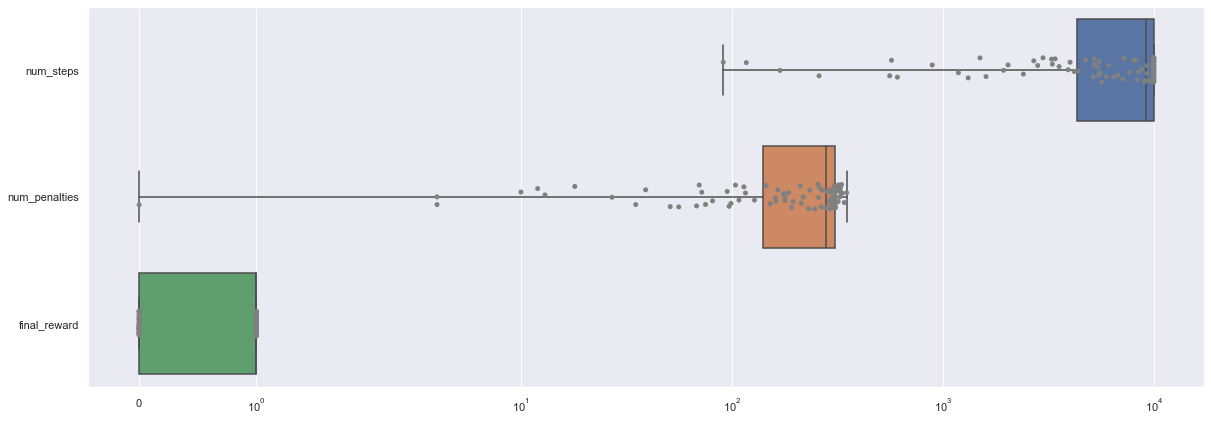

In [14]:
fig, ax = plt.subplots(figsize=(20, 7))
ax.set_xscale('symlog')
sns.boxplot(data=no_slip_exps, ax=ax, orient='h')
sns.stripplot(data=no_slip_exps, ax=ax, orient='h', color='gray')
plt.show()

In [15]:
# In the Taxi Environment there exists some penalties "negative rewards" involved, so when plotting the graph, we can see that
# the final rewards will vary, not just "1" in the case of Frozen Lake.
# The fact that the only reward mentioned in the frozen lake is the last reward "When reaching the goal" will result in a huge
# number of times hitting holes as we can see in the graph.

<h2>Tackling the Environment with $Q$-Learning</h2>
<p>In a simplified version of $Q$-learning, the <b>$\boldsymbol{Q}$-value</b>
\begin{equation}
    Q(s,a)
\end{equation}</p>

<p>is the expected future reward of being in state $s$ and taking action $a$. Intuitively, if the $Q$-values are learned correctly, a good policy would be to take the action which maximizes the expected future reward. This is what $Q$-learning is doing. $Q$-learning lets the agent <b>use the environment's rewards to learn</b>, over time, the best action to take in a given state. $Q$-values are initialized to an arbitrary value, and as the agent exposes itself to the environment and receives different rewards by executing different actions, the $Q$-values are updated using the equation:
\begin{equation}
    Q(s_t,a_t) \leftarrow (1 - \alpha) \cdot Q(s_t,a_t) + \alpha \cdot \left( r + \gamma \max_{a_{t+1}} Q(s_{t+1}, a_{t+1})\right)
\end{equation}</p>

<p>We are assigning $\leftarrow$, or updating, the $Q$-value of the agent's current state and action, denoted as $Q(s_t,a_t)$ with $\alpha$ as the learning rate, i.e the extent to which our $Q$-values are being updated in every iteration.</p>

<p>The <b>$\boldsymbol{Q}$-table</b> is a matrix where we have a row for every state and a column for every action: $64$ and $4$, respectively, when referring to the current <i>FrozenLake</i> example. It's first initialized to $0$, and then values are updated during training.</p>

<p>Previously, we talked about solving this task in a na&#xEF;ve way by simply applying <i>brute force</i> using <i>random search</i>. This time, we want to apply a more sophisticated algorithm, namely $Q$-learning:
<ul>
    <li><code>I</code> $\rightarrow$ Choose action $a_t$.
    <li><code>II</code> $\rightarrow$ Go from state $s_t$ to state $s_{t+1}$ by taking action $a_{t}$.
    <li><code>III</code> $\rightarrow$ For all possible $Q$-values from the state $s_{t+1}$, select the highest.
    <li><code>IV</code> $\rightarrow$ Update $Q$-table values using the equation from above.
    <li><code>V</code> $\rightarrow$ Set the next state as the current state and go back to <code>I</code> until a final state is reached (end of episode).
</ul>

This procedure is repeated for as many episodes as specified (<code>VI</code>).</p>

<div class="alert alert-warning">
    <b>Exercise 3.1 [10 Points]</b>
    <ul>
        <li>Implement <i>$Q$-learning</i> as outlined above (equivalently to the one discussed during the exercise).</li>
        <li>Apply $Q$-learning on a freshly $42$-seeded <code>FrozenLakeEnv</code> instance for $50,000$ episodes, with $1,000$ delay steps, a discount factor $\gamma=0.99$ and $\alpha=0.1$.</li>
        <li>Interpret the visualization of the resulting $Q$-table. What do you observe? Why do you observe this effect?</li>
    </ul>
</div>

<div class="alert alert-warning">
    The following code snippet is taken from the accompanying exercise notebook. You do not need to modify it for this assignment.
</div>

In [16]:
# Original Code
def visualize_q_table(q_table: np.ndarray, title: str = '') -> None:
    """
    Visualize Q-table using a heatmap plot.
    
    :param q_table: Q-table to visualize
    """
    sns.set()
    fig, ax = plt.subplots(figsize=(20, 7))
    sns.heatmap(data=q_table, ax=ax)
    ax.set(xlabel='Action', ylabel='State', title=title)
    display.clear_output(wait=True)
    display.display(fig)
    plt.close(fig=fig)


def apply_q_learning(environment: gym.Env, num_episodes: int = 1000, alpha: float = 0.1, gamma: float = 1.0,
                     animate: bool = False, delay_steps: int = 100) -> np.ndarray:
    """
    Solve specified environment by applying Q-learning.
    
    :param environment: the environment on which to apply Q-learning
    :param num_episodes: the total amount of episodes used to adapt the Q-table
    :param alpha: the learning rate to be applied by Q-learning
    :param gamma: the discount factor of future rewards
    :param animate: animate the Q-learning process
    :param delay_steps: the steps between each Q-table visualization (ignored if not animated)
    :return: adapted Q-table
    """
    q_table = np.zeros(shape=(environment.observation_space.n, environment.action_space.n))
    
    # <VI>: repeat Q-learning as long as the total amount of episodes is not yet reached.
    for episode in range(num_episodes):
        state = environment.reset()
        
        done = False
        while not done:
            
            # <I>: choose next action according to current Q-table.
            action = np.argmax(q_table[state]) 
            
            # <II>: go from the current state to the next by applying chosen action.
            next_state, reward, done, info = environment.step(action)
            
            # <III>: from all possible Q-values w.r.t. the new state, select the highest.
            next_max = np.max(q_table[next_state])
            
            # <IV>: update the Q-table accordingly.
            old_value = q_table[state, action]
            new_value = (1 - alpha) * old_value + alpha * (reward + gamma * next_max)
            q_table[state, action] = new_value

            # <V>: update the next step with the current one.
            state = next_state
        
        # Optionally visualize the current Q-table.
        if animate and any(((episode + 1) % delay_steps == 0, (episode + 1) == num_episodes)):
            visualize_q_table(q_table=q_table, title=f'Episode {episode + 1}')
    
    return q_table

In [ ]:
u6.set_environment_seed(environment=no_slip_env, seed=42)
q_table = apply_q_learning(environment=no_slip_env, num_episodes=50000, gamma=0.99,
                            alpha=0.1, animate=True, delay_steps=1000)

# The Code was stopped after 72 hours without yielding any results.
# This is due to the fact that the q-table was initialized as zeros, and since the environment doesn't have any penalties
# the action will always remain 0 -to go left- which yields nothing which results in an inifinite loop, and prevent the animate
# to occur, but most likely it will yield a blank plot indicating no learning happening, for the above reasons

In [17]:
# Slightly Modified to escape the infinite loop
def visualize_q_table(q_table: np.ndarray, title: str = '') -> None:
    """
    Visualize Q-table using a heatmap plot.
    
    :param q_table: Q-table to visualize
    """
    sns.set()
    fig, ax = plt.subplots(figsize=(20, 7))
    sns.heatmap(data=q_table, ax=ax)
    ax.set(xlabel='Action', ylabel='State', title=title)
    display.clear_output(wait=True)
    display.display(fig)
    plt.close(fig=fig)


def apply_q_learning(environment: gym.Env, num_episodes: int = 1000, alpha: float = 0.1, gamma: float = 1.0,
                     animate: bool = False, delay_steps: int = 100) -> np.ndarray:
    """
    Solve specified environment by applying Q-learning.
    
    :param environment: the environment on which to apply Q-learning
    :param num_episodes: the total amount of episodes used to adapt the Q-table
    :param alpha: the learning rate to be applied by Q-learning
    :param gamma: the discount factor of future rewards
    :param animate: animate the Q-learning process
    :param delay_steps: the steps between each Q-table visualization (ignored if not animated)
    :return: adapted Q-table
    """
    q_table = np.zeros(shape=(environment.observation_space.n, environment.action_space.n))
    
    # <VI>: repeat Q-learning as long as the total amount of episodes is not yet reached.
    for episode in range(num_episodes):
        state = environment.reset()
        
        done = False
        while not done:
            
            # <I>: choose next action according to current Q-table.
            action = np.argmax(q_table[state]) if np.max(q_table[state]) > 0 else environment.action_space.sample()

            # <II>: go from the current state to the next by applying chosen action.
            next_state, reward, done, info = environment.step(action)
            
            # <III>: from all possible Q-values w.r.t. the new state, select the highest.
            next_max = np.max(q_table[next_state])
            
            # <IV>: update the Q-table accordingly.
            old_value = q_table[state, action]
            new_value = (1 - alpha) * old_value + alpha * (reward + gamma * next_max)
            q_table[state, action] = new_value
            # <V>: update the next step with the current one.
            state = next_state
        
        # Optionally visualize the current Q-table.
        if animate and any(((episode + 1) % delay_steps == 0, (episode + 1) == num_episodes)):
            visualize_q_table(q_table=q_table, title=f'Episode {episode + 1}')
    
    return q_table

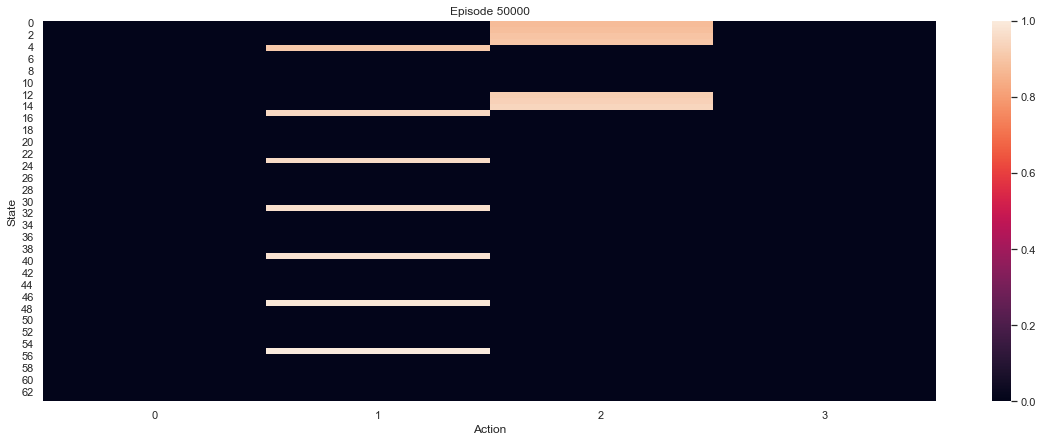

In [18]:
u6.set_environment_seed(environment=no_slip_env, seed=42)
q_table = apply_q_learning(environment=no_slip_env, num_episodes=50000, gamma=0.99,
                            alpha=0.1, animate=True, delay_steps=1000)

In [19]:
# The graph Indicates that learning will be very slow without any penalties in the environment and with an initial zero q-table
# Also if the Left action was not escaped it should've displayed an empty graph since there will be no actions taken ever.
# This also can be reproduced by a max_step implementation like done in the previous exercise.

<p>Very likely, the $Q$-table of the previous experiment looked a little bit odd. Try to add an initial exploration to your algorithm by adapting your $Q$-learning implementation:
    <ul>
        <li><code>I</code> $\rightarrow$ Get a random uniform number between $0$ and $1$. 
        <li><code>II</code> $\rightarrow$ If the number is smaller than <code>1 - episode / (num_episodes - 1)</code>, sample a random action.
        <li><code>III</code> $\rightarrow$ Otherwise, choose your action as usual.
    </ul>
</p>

<div class="alert alert-warning">
    <b>Exercise 3.2 [20 Points]</b>
    <ul>
        <li>Modify the <i>$Q$-learning</i> implementation from the previous tasks as outlined above (mark the corresponding code sections).</li>
        <li>Apply $Q$-learning on a freshly $42$-seeded <code>FrozenLakeEnv</code> instance for $50,000$ episodes, with $1,000$ delay steps, discount factor $\gamma=0.99$ and $\alpha=0.1$.</li>
        <li>Interpret the visualization of the resulting $Q$-table. What do you observe (compare with the previous visualization)?</li>
        <li>Use this $Q$-learning strategy to also tackle the <code>FrozenLakeEnv</code> with <code>slippery = True</code>. Compare both $Q$-tables and discuss the differences.</li>
    </ul>
</div>

In [20]:
def apply_q_learning(environment: gym.Env, num_episodes: int = 1000, alpha: float = 0.1, gamma: float = 1.0,
                     animate: bool = False, delay_steps: int = 100) -> np.ndarray:
    """
    Solve specified environment by applying Q-learning.
    
    :param environment: the environment on which to apply Q-learning
    :param num_episodes: the total amount of episodes used to adapt the Q-table
    :param alpha: the learning rate to be applied by Q-learning
    :param gamma: the discount factor of future rewards
    :param animate: animate the Q-learning process
    :param delay_steps: the steps between each Q-table visualization (ignored if not animated)
    :return: adapted Q-table
    """
    q_table = np.zeros(shape=(environment.observation_space.n, environment.action_space.n))
    
    # <VI>: repeat Q-learning as long as the total amount of episodes is not yet reached.
    for episode in range(num_episodes):
        state = environment.reset()
        
        done = False
        while not done:
            
            # <I>: get a random number between [0,1]
            random_var = np.random.uniform(low=0,high=1)
            # <II>: if random_var < (1-(episode/(num_episodes-1))) choose a random action
            if random_var < (1-(episode/(num_episodes-1))):
                action = environment.action_space.sample()
            else:
            # <III>: choose next action according to current Q-table.
                action  = np.argmax(q_table[state])
            
            # <IV>: go from the current state to the next by applying chosen action.
            next_state, reward, done, info = environment.step(action)
            
            # <V>: from all possible Q-values w.r.t. the new state, select the highest.
            next_max = np.max(q_table[next_state])
            
            # <VI>: update the Q-table accordingly.
            old_value = q_table[state, action]
            new_value = (1 - alpha) * old_value + alpha * (reward + gamma * next_max)
            q_table[state, action] = new_value

            # <VII>: update the next step with the current one.
            state = next_state
        
        # Optionally visualize the current Q-table.
        if animate and any(((episode + 1) % delay_steps == 0, (episode + 1) == num_episodes)):
            visualize_q_table(q_table=q_table, title=f'Episode {episode + 1}')
    
    return q_table

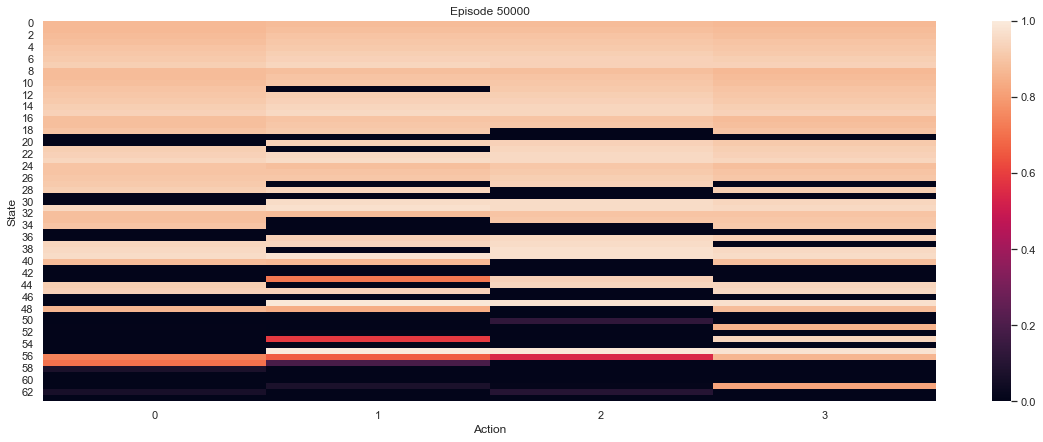

In [21]:
u6.set_environment_seed(environment=no_slip_env, seed=42)
q_table_noslip_rand = apply_q_learning(environment=no_slip_env, num_episodes=50000,
                                        gamma=0.99, alpha=0.1, animate=True, delay_steps=1000)

In [22]:
# The Q-table shows that it was in fact able to learn how to solve the task successfully, in a considerably faster pace "Steps"
# than the previous "slightly modified code" and even with the "empty graph of the code provided" 
# and this was due to the random initialization of the q-table

In [23]:
slip_env = FrozenLakeEnv(slippery=True).env
u6.set_environment_seed(environment=slip_env, seed=42)
print(slip_env.render(mode='ansi'))


SFFFFFFF
FFFFFFFF
FFFHFFFF
FFFFFHFF
FFFHFFFF
FHHFFFHF
FHFFHFHF
FFFHFFFG



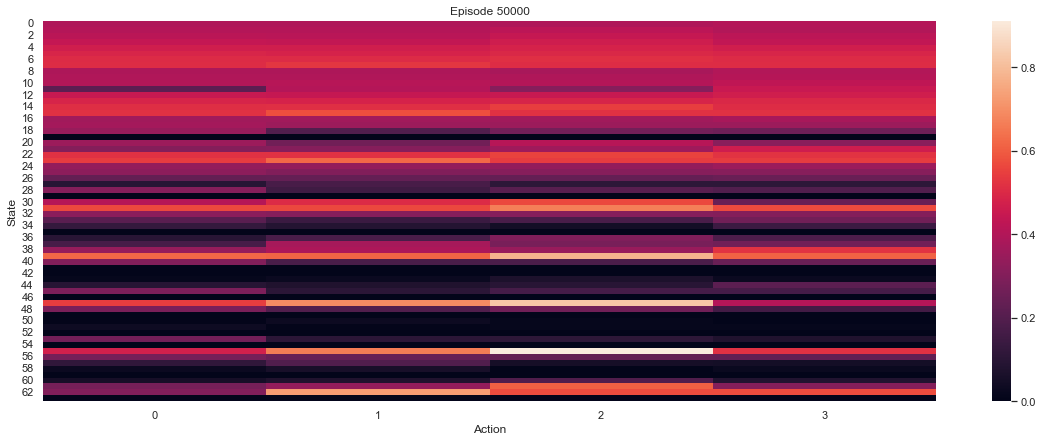

In [24]:
u6.set_environment_seed(environment=slip_env, seed=42)
q_table_slip_rand = apply_q_learning(environment=slip_env, num_episodes=50000,
                                    gamma=0.99, alpha=0.1, animate=True, delay_steps=1000)

In [25]:
# When applying the slippery environment over the q-table trained on non-slippery env. we get that it's performing worse than
# the original non-slippery in the range of "33%" worse because there's a random factor applied while taking each step, which
# will deffinetly affect the performance of the algorithm that never took into account this randomness

<div class="alert alert-warning">
    <b>Exercise 3.3 [15 Points]</b>
    <ul>
        <li>Implement a function for applying a pre-trained $Q$-table on a <code>FrozenLakeEnv</code> instance (like discussed during class).</li>
        <li>For both <code>FrozenLakeEnv</code> instances (with <code>slippery = False</code> and <code>slippery = True</code>), conduct a guided search using the corresponding $Q$-table on a freshly $42$-seeded instance, with an animation delay of $0.1$.</li>
        <li>Answer the following question for both settings: How many steps are necessary to reach the goal at least once and how often did an involuntary dive happen?</li>
        <li>Compare the corresponding policies of each $Q$-table. Which property of the environment is exploited in the slippery policy to avoid involuntary dives?</li>
    </ul>
</div>

In [26]:
def apply_q_table(environment: gym.Env, q_table: np.ndarray, animate: bool = False,
                  delay: float = 0.1) -> Tuple[int, int, int]:
    """
    Solve specified environment by applying specified Q-table.
    
    :param environment: the environment on which to apply Q-table guided search
    :param q_table: the Q-table used during Q-table guided search
    :param animate: animate the Q-table guided search process
    :param delay: the minimum delay in milliseconds between each rendered frame (ignored if not animated)
    :return: amount of steps performed, penalties inflicted and final reward
    """
    num_steps, num_penalties, final_reward = 0, 0, 0
    
    # <III>: repeat Q-table guided search procedure as long as the episode is still ongoing.
    done = False
    while not done:
        
        # <I>: choose action according to the Q-table with respect to the current state.
        current_action = np.argmax(q_table[environment.s])
        
        # <II>: execute previously chosen action and transition into a new state.
        current_state, current_reward, done, info = environment.step(current_action)
        
        # Update counter for inflicted penalties.
        final_reward += current_reward
        if done and current_reward != 1:
            num_penalties += 1
        num_steps += 1
        
        # Optionally display current state.
        if animate:
            display.clear_output(wait=True)
            print(environment.render(mode='ansi'))
            print(f'Step No.: {num_steps}'
                  f'\nState ID: {current_state}'
                  f'\nAction ID: {current_action}'
                  f'\nReward: {current_reward}')
            time.sleep(delay)
    
    return num_steps, num_penalties, final_reward

In [27]:
no_slip_env = FrozenLakeEnv(slippery=False).env
u6.set_environment_seed(environment=no_slip_env, seed=42)

In [28]:
num_steps, num_penalties, final_reward = apply_q_table(environment=no_slip_env, q_table=q_table, animate=True, delay=0.1)
print('\nNon-Slippery')
print(f'[Exploitation Only]\n=============\nNumber of Steps:\t{num_steps}\nNumber of Holes:\t{num_penalties}')

  (Down)
SFFFFFFF
FFFFFFFF
FFFHFFFF
FFFFFHFF
FFFHFFFF
FHHFFFHF
FHFFHFHF
FFFHFFFG

Step No.: 14
State ID: 63
Action ID: 1
Reward: 1.0

Non-Slippery
[Exploitation Only]
Number of Steps:	14
Number of Holes:	0


In [29]:
no_slip_env = FrozenLakeEnv(slippery=False).env
u6.set_environment_seed(environment=no_slip_env, seed=42)

In [30]:
num_steps, num_penalties, final_reward = apply_q_table(environment=no_slip_env, q_table=q_table_noslip_rand, animate=True,
                                                       delay=0.1)
print('\nNon-Slippery')
print(f'[Exploration Involved]\n=============\nNumber of Steps:\t{num_steps}\nNumber of Holes:\t{num_penalties}')

  (Down)
SFFFFFFF
FFFFFFFF
FFFHFFFF
FFFFFHFF
FFFHFFFF
FHHFFFHF
FHFFHFHF
FFFHFFFG

Step No.: 14
State ID: 63
Action ID: 1
Reward: 1.0

Non-Slippery
[Exploration Involved]
Number of Steps:	14
Number of Holes:	0


In [31]:
slip_env = FrozenLakeEnv(slippery=True).env
u6.set_environment_seed(environment=slip_env, seed=42)

In [32]:
u6.set_environment_seed(environment=slip_env, seed=42)
num_steps, num_penalties, final_reward = apply_q_table(environment=slip_env, q_table=q_table_slip_rand, animate=True, delay=0.1)
print('\nSlippery')
print(f'[Exploration Involved]\n=============\nNumber of Steps:\t{num_steps}\nNumber of Holes:\t{num_penalties}')

  (Right)
SFFFFFFF
FFFFFFFF
FFFHFFFF
FFFFFHFF
FFFHFFFF
FHHFFFHF
FHFFHFHF
FFFHFFFG

Step No.: 74
State ID: 63
Action ID: 2
Reward: 1.0

Slippery
[Exploration Involved]
Number of Steps:	74
Number of Holes:	0


In [33]:
# Slippery Policy almost identified the optimum path to reach the goal, while the Slippery Policy accounts for some uncertainty
# in the movement.

In [34]:
# Which property of the environment is exploited in the slippery policy to avoid involuntary dives?
# When Reaching a Slippery Surface, if the movement was not implemented as intended
# The Policy Return back to previous non-slippery surface and then re-do the same action until it reaches the goal.

<div class="alert alert-warning">
    <b>Exercise 3.4 [15 Points]</b>
    <ul>
        <li>Conduct a <i>$Q$-table guided search experiment</i> on the non-slippery environment, as outlined previously, using $100$ repetitions and the random seed set to $42$.</li>
        <li>Interpret the visualization (e.g. the span of the boxes) and keep the scaling of the <i>x-axis</i> in mind.</li>
        <li>In comparison with the <i>random search</i> experiment, how does the $Q$-table guided search perform? Discuss the results.</li>
    </ul>
</div>

In [35]:
u6.set_environment_seed(environment=no_slip_env, seed=42)

num_reps = 100
q_exps = []

for i in range(num_reps):
    no_slip_env.reset()
    q_exps.append(apply_q_table(environment=no_slip_env, q_table=q_table_noslip_rand, animate=False))
qtable_exps = pd.DataFrame(q_exps, columns=['num_steps', 'num_penalties', 'final_reward'])
qtable_exps

,num_steps,num_penalties,final_reward
0,14,0,1.0
1,14,0,1.0
2,14,0,1.0
3,14,0,1.0
4,14,0,1.0
...,...,...,...
95,14,0,1.0
96,14,0,1.0
97,14,0,1.0
98,14,0,1.0


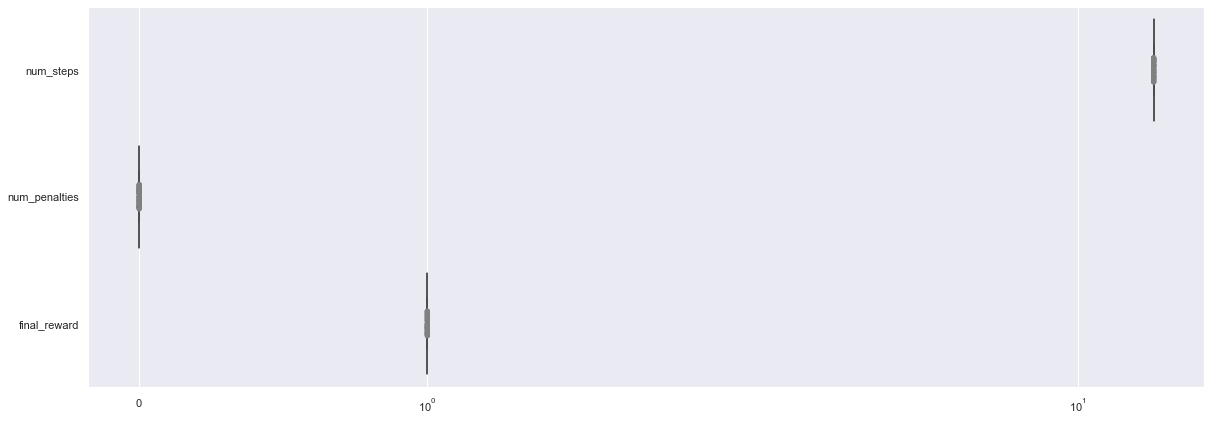

In [36]:
fig, ax = plt.subplots(figsize=(20, 7))
ax.set_xscale('symlog')
sns.boxplot(data=qtable_exps, ax=ax, orient='h')
sns.stripplot(data=qtable_exps, ax=ax, orient='h', color='gray')
plt.show()

In [37]:
# The Graph Shows that the q-table was able to learn the optimum path which it will prefer over any other every time, to
# reach the goal with a 100% probability

In [38]:
# In Comparison with random search, the latter takes actions based on randomness, which there's a much higher probability of
# falling into a hole, which can be seen in the number of penalties, as well as the number of steps vary widely.

<div class="alert alert-warning">
    <b>Exercise 3.5 [15 Points]</b>
    <ul>
        <li>Repeat the <i>$Q$-table guided search experiment</i> using $100$ repetitions and the random seed set to $42$. This time we would like to compare both policies (learned for the slippery and non-slippery environment) on the slippery environment. Hence, you have to apply the non-slippery $Q$-table to the slippery environment and also the slippery $Q$-table to the same environment. Remember to reset the seed.</li>
        <li>Compare the number of performed steps as well as the performed dives using box- and strip-(swarm-) plots. Discuss your observations.</li>
    </ul>
</div>

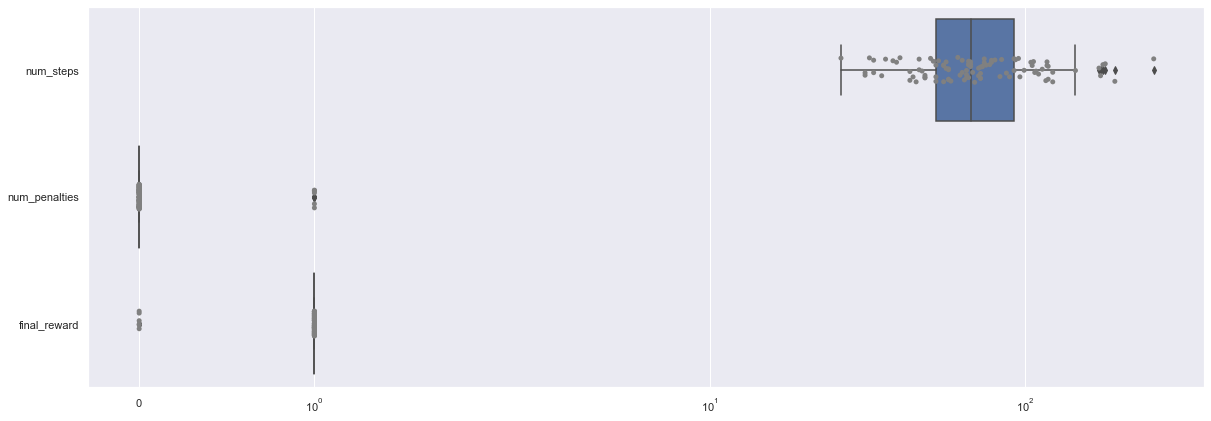

In [39]:
# Slippery Env -> Slippery Q-table
u6.set_environment_seed(environment=slip_env, seed=42)

num_reps = 100
q_exps = []

for i in range(num_reps):
    slip_env.reset()
    q_exps.append(apply_q_table(environment=slip_env, q_table=q_table_slip_rand, animate=False))
qtable_exps = pd.DataFrame(q_exps, columns=['num_steps', 'num_penalties', 'final_reward'])

fig, ax = plt.subplots(figsize=(20, 7))
ax.set_xscale('symlog')
sns.boxplot(data=qtable_exps, ax=ax, orient='h')
sns.stripplot(data=qtable_exps, ax=ax, orient='h', color='gray')
plt.show()

In [40]:
# When Comparing the Slippery Policy and the Non-Slippery Policy "Each on its respective environment",
# We see that the "Slippery Policy" in fact sometimes fail to reach the goal and step into some holes, also the number of the
# steps vary within the range of approximately 50 to 150
# In contrast with the "Non-Slippery Policy" -plotted previously- It succeeds to reach the goal everytime because the actions will
# always remain the same "without any probability of randomness"

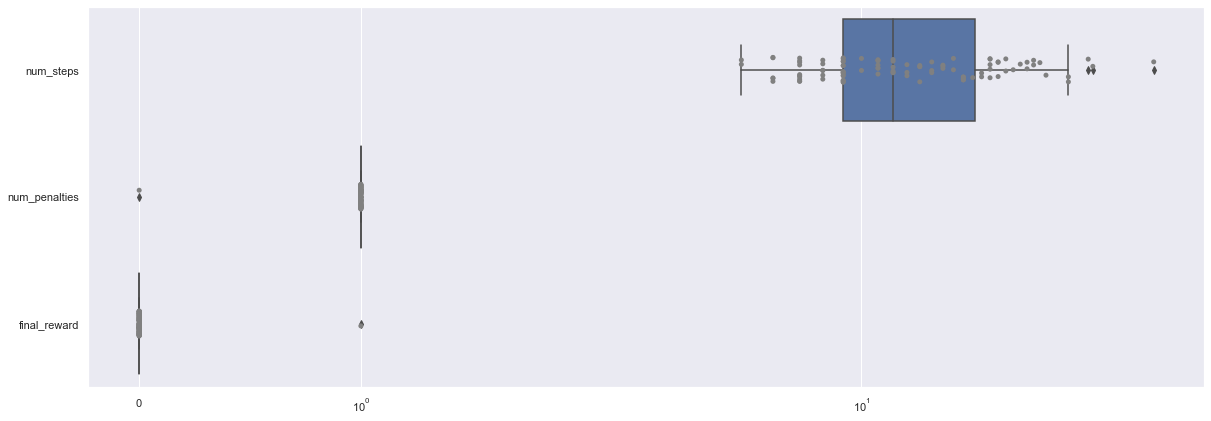

In [41]:
# Slippery Env -> Non-Slippery Q-table
u6.set_environment_seed(environment=slip_env, seed=42)

num_reps = 100
q_exps = []

for i in range(num_reps):
    slip_env.reset()
    q_exps.append(apply_q_table(environment=slip_env, q_table=q_table_noslip_rand, animate=False))
qtable_exps = pd.DataFrame(q_exps, columns=['num_steps', 'num_penalties', 'final_reward'])

fig, ax = plt.subplots(figsize=(20, 7))
ax.set_xscale('symlog')
sns.boxplot(data=qtable_exps, ax=ax, orient='h')
sns.stripplot(data=qtable_exps, ax=ax, orient='h', color='gray')
plt.show()

In [42]:
# When Comparing the "Policy of Non-Slippery" Environment applied on the "Slippery Environment" with
# The "Policy of the Non-Slippery" Environment applied on "its particular environment",
# We can See that the number of steps is much bigger, as explained previously, moreover the number of penalties is also more
# often than the number of penalties of the "Policy of Slippery" Environment -represented in where is the box located, and
# where is the outliers-